In [62]:
import numpy as np
import matplotlib.pyplot as plt

file_path = '/Users/kimdaehyeok/Desktop/Kimgroup/Project/GCMD/data/0.4-2eqNM/spm_lj.lammpstrj'
file = '/Users/kimdaehyeok/Desktop/Kimgroup/Project/GCMD/data/0.4-2eqNM/'
rmax = 10.0  # Max distance for RDF
dr = 0.05     # Distance bin size

# class define

In [63]:
class ComputeRDF:
    def __init__(self, rmax, dr):
        self.dr = dr
        self.rmax = rmax
        self.nbins = int(np.ceil(rmax / dr))

    def apply_pbc(self, delta, box):
        for k in range(3):  # Adjust for 3D box
            delta[k] -= np.round(delta[k] / box[k]) * box[k]
        return delta

    def get_numbers(self, snap, selected1, selected2):
        nselected_a = 0
        nselected_b = 0
        for si in snap:  
            if si[1] in selected1:
                nselected_a += 1
            if si[1] in selected2:
                nselected_b += 1
        return nselected_a, nselected_b

    def calc_gr(self, snap, box, selected1, selected2):
        gr = np.zeros(self.nbins)
        vol = np.prod(box)  
        natom = len(snap)  
        density = natom / vol  

        nselected_a, nselected_b = self.get_numbers(snap, selected1, selected2)
        density_a = nselected_a / vol
        density_b = nselected_b / vol

        add = 1
        for i, si in enumerate(snap):
            if si[1] in selected1:
                for j, sj in enumerate(snap):
                    if sj[1] in selected2:
                        if i == j:
                            continue
                        delta = np.array(si[2:]) - np.array(sj[2:])
                        delta = self.apply_pbc(delta, box)
                        r = np.linalg.norm(delta)
                        if r <= self.rmax:
                            bin_index = int(r / self.dr)
                            if bin_index < self.nbins:
                                gr[bin_index] += add

        bins = np.array([(i * self.dr + (i + 1) * self.dr) / 2 for i in range(self.nbins)])
        for i in range(self.nbins):
            r_inner = i * self.dr
            r_outer = (i + 1) * self.dr
            shell_volume = 4.0 / 3.0 * np.pi * (r_outer**3 - r_inner**3)
            ideal_gas_count = (
                0.5 * (density_a * nselected_b + density_b * nselected_a) * shell_volume
            )
            gr[i] /= ideal_gas_count
        return gr, bins



In [64]:
class LammpsDumpParser:
    def __init__(self, traj="mytraj.lammpstrj", dump_style="id type xu yu zu"):
        self.traj = traj
        self.freqprint = 500
        self.dump_style = dump_style

    def get_box_lengths(self, lines):
        lengths = []
        for line in lines:
            l = line.rstrip().split()
            low = float(l[0]) 
            high = float(l[1])  
            length = high - low
            lengths.append(length)
        return lengths

    def parse(self):
        nsnap = 1
        xyz = []  
        box = []
        with open(self.traj, 'r') as fin:
            while True:
                l = fin.readline()  
                if not l.strip():
                    print("Reading trajectory completed.")
                    break
                timestep = int(fin.readline())  

                if nsnap % self.freqprint == 0:
                    print(f"{nsnap}th snapshot of timestep {timestep} reading...")

                fin.readline()  
                natoms = int(fin.readline())

                fin.readline()  
                bx = fin.readline()  
                by = fin.readline()  
                bz = fin.readline()  
                bb = self.get_box_lengths([bx, by, bz])  
                box.append(bb)  

                xs = []  
                fin.readline()  
                for i in range(natoms):
                    idx, atype, x, y, z = fin.readline().split()
                    xs.append([int(idx) - 1, int(atype), float(x), float(y), float(z)])
                xyz.append([timestep, xs])
                nsnap += 1
        self.xyz = xyz
        self.box = box

# calculation (gacr,gccr,gaar,gzzr)

500th snapshot of timestep 2495000 reading...
1000th snapshot of timestep 4995000 reading...
Reading trajectory completed.


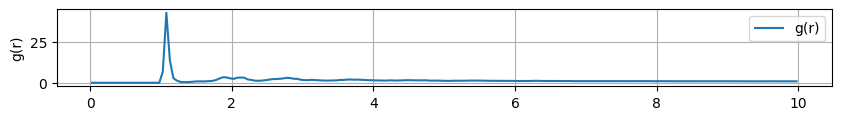

In [65]:
#gacr

# Select particle types for RDF calculation
# Atom type setting
# 1:Solvent(not used)
# 2:Cation charge 1
# 3:Anion charge -1
selected1 = [2]
selected2 = [3] 

# Initialize and compute RDF
rdf_calculator = ComputeRDF(rmax, dr)

# Parse LAMMPS trajectory to extract snapshot data
parser = LammpsDumpParser(traj=file_path)
parser.parse()

# Use the first snapshot for RDF calculation
snap = parser.xyz[0][1]
box = parser.box[0]

# Calculate RDF
gr, bins = rdf_calculator.calc_gr(snap, box, selected1, selected2)

# Save RDF data to a text file
rdf_data = np.column_stack((bins, gr))  # Combine bins and gr arrays
np.savetxt(file+"gacr.txt", rdf_data, header="Distance (r)    g(r)", fmt="%.6f")

# Plot RDF
plt.figure(figsize=(10, 1))
plt.plot(bins, gr, label='g(r)')
#plt.xlabel('Distance (r)')
plt.ylabel('g(r)')
#plt.title('Radial Distribution Function (RDF)')
plt.legend()
plt.grid()
plt.show()


500th snapshot of timestep 2495000 reading...
1000th snapshot of timestep 4995000 reading...
Reading trajectory completed.


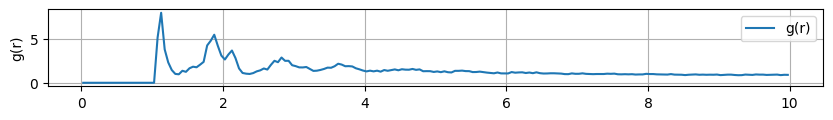

In [66]:
#gccr

# Select particle types for RDF calculation
# Atom type setting
# 1:Solvent(not used)
# 2:Cation charge 1
# 3:Anion charge -1
selected1 = [2]
selected2 = [2] 

# Initialize and compute RDF
rdf_calculator = ComputeRDF(rmax, dr)

# Parse LAMMPS trajectory to extract snapshot data
parser = LammpsDumpParser(traj=file_path)
parser.parse()

# Use the first snapshot for RDF calculation
snap = parser.xyz[0][1]
box = parser.box[0]

# Calculate RDF
gr, bins = rdf_calculator.calc_gr(snap, box, selected1, selected2)

# Save RDF data to a text file
rdf_data = np.column_stack((bins, gr))  # Combine bins and gr arrays
np.savetxt(file+"gccr.txt", rdf_data, header="Distance (r)    g(r)", fmt="%.6f")

# Plot RDF
plt.figure(figsize=(10, 1))
plt.plot(bins, gr, label='g(r)')
#plt.xlabel('Distance (r)')
plt.ylabel('g(r)')
#plt.title('Radial Distribution Function (RDF)')
plt.legend()
plt.grid()
plt.show()


500th snapshot of timestep 2495000 reading...
1000th snapshot of timestep 4995000 reading...
Reading trajectory completed.


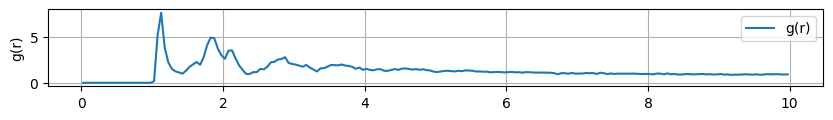

In [67]:
#gaar

# Select particle types for RDF calculation
# Atom type setting
# 1:Solvent(not used)
# 2:Cation charge 1
# 3:Anion charge -1
selected1 = [3]
selected2 = [3] 

# Initialize and compute RDF
rdf_calculator = ComputeRDF(rmax, dr)

# Parse LAMMPS trajectory to extract snapshot data
parser = LammpsDumpParser(traj=file_path)
parser.parse()

# Use the first snapshot for RDF calculation
snap = parser.xyz[0][1]
box = parser.box[0]

# Calculate RDF
gr, bins = rdf_calculator.calc_gr(snap, box, selected1, selected2)

# Save RDF data to a text file
rdf_data = np.column_stack((bins, gr))  # Combine bins and gr arrays
np.savetxt(file+"gaar.txt", rdf_data, header="Distance (r)    g(r)", fmt="%.6f")

# Plot RDF
plt.figure(figsize=(10, 1))
plt.plot(bins, gr, label='g(r)')
#plt.xlabel('Distance (r)')
plt.ylabel('g(r)')
#plt.title('Radial Distribution Function (RDF)')
plt.legend()
plt.grid()
plt.show()


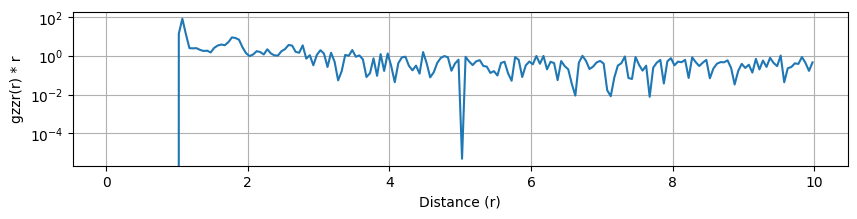

In [68]:
# calculate gzz(r)

# Load data from the files
gacr = np.loadtxt(file+"gacr.txt", skiprows=1)
gaar = np.loadtxt(file+"gaar.txt", skiprows=1)
gccr = np.loadtxt(file+"gccr.txt", skiprows=1)

# Ensure all files have the same distance values
r_values = gacr[:, 0]
assert np.allclose(r_values, gaar[:, 0]) and np.allclose(r_values, gccr[:, 0]), "Distance values do not match."

# Perform the calculation
gzzr_values = gaar[:, 1] + gccr[:, 1] - 2 * gacr[:, 1]
gzzr = np.abs(gzzr_values)

# Save the result to gzzr.txt
gzzr_data = np.column_stack((r_values, gzzr))
np.savetxt(file+"gzzr.txt", gzzr_data, header="Distance (r)    gzzr(r)", fmt="%.6f")

# gzzr 값에 r 값을 곱한 값 계산
gzzr_times_r = gzzr * r_values

# Plot the result (gzzr(r) * r)
plt.figure(figsize=(10, 2))
plt.yscale('log')
plt.plot(r_values, gzzr_times_r, label='gzzr(r) * r')
plt.xlabel('Distance (r)')
plt.ylabel('gzzr(r) * r')
#plt.title('Calculated gzzr(r) * r')
#plt.legend()
plt.grid()
plt.show()
